In [ ]:
cd /content/drive/My Drive/BVsegmentation/BV

/content/drive/My Drive/BVsegmentation/BV


In [ ]:
#preparing dataset...
#read all the train and test samples and save them as a hdf5 file in the DRIVE_datasets_training_testing folder.


from __future__ import division
#==========================================================
#
#  This prepare the hdf5 datasets of the DRIVE database
#
#============================================================

import os
import h5py
import numpy as np
from PIL import Image



def write_hdf5(arr,outfile):
  with h5py.File(outfile,"w") as f:
    f.create_dataset("image", data=arr, dtype=arr.dtype)


#------------Path of the images --------------------------------------------------------------
#train
original_imgs_train = "./DRIVE/training/images/"
groundTruth_imgs_train = "./DRIVE/training/1st_manual/"
borderMasks_imgs_train = "./DRIVE/training/mask/"
#test
original_imgs_test = "./DRIVE/test/images/"
groundTruth_imgs_test = "./DRIVE/test/1st_manual/"
borderMasks_imgs_test = "./DRIVE/test/mask/"
#---------------------------------------------------------------------------------------------

Nimgs = 32
channels = 3
height = 584
width = 565
dataset_path = "./DRIVE_datasets_training_testing/"

def get_datasets(imgs_dir,groundTruth_dir,borderMasks_dir,train_test="null"):
    imgs = np.empty((Nimgs,height,width,channels))
    groundTruth = np.empty((Nimgs,height,width))
    border_masks = np.empty((Nimgs,height,width))
    for path, subdirs, files in os.walk(imgs_dir): #list all files, directories in the path
        for i in range(len(files)):
            #original
            print ("original image: " +files[i])
            img = Image.open(imgs_dir+files[i])
            imgs[i] = np.asarray(img)
            #corresponding ground truth
            groundTruth_name = files[i][0:2] + "_manual1.gif"
            print ("ground truth name: " + groundTruth_name)
            g_truth = Image.open(groundTruth_dir + groundTruth_name)
            groundTruth[i] = np.asarray(g_truth)
            #corresponding border masks
            border_masks_name = ""
            if train_test=="train":
                border_masks_name = files[i][0:2] + "_training_mask.gif"
            elif train_test=="test":
                border_masks_name = files[i][0:2] + "_test_mask.gif"
            else:
                print ("specify if train or test!!")
                exit()
            print ("border masks name: " + border_masks_name)
            b_mask = Image.open(borderMasks_dir + border_masks_name)
            border_masks[i] = np.asarray(b_mask)

    print ("imgs max: " +str(np.max(imgs)))
    print ("imgs min: " +str(np.min(imgs)))
    assert(np.max(groundTruth)==255 and np.max(border_masks)==255)
    assert(np.min(groundTruth)==0 and np.min(border_masks)==0)
    print ("ground truth and border masks are correctly withih pixel value range 0-255 (black-white)")
    #reshaping for my standard tensors
    imgs = np.transpose(imgs,(0,3,1,2))
    assert(imgs.shape == (Nimgs,channels,height,width))
    groundTruth = np.reshape(groundTruth,(Nimgs,1,height,width))
    border_masks = np.reshape(border_masks,(Nimgs,1,height,width))
    assert(groundTruth.shape == (Nimgs,1,height,width))
    assert(border_masks.shape == (Nimgs,1,height,width))
    return imgs, groundTruth, border_masks

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
#getting the training datasets
imgs_train, groundTruth_train, border_masks_train = get_datasets(original_imgs_train,groundTruth_imgs_train,borderMasks_imgs_train,"train")
print ("saving train datasets")
write_hdf5(imgs_train, dataset_path + "DRIVE_dataset_imgs_train.hdf5")
write_hdf5(groundTruth_train, dataset_path + "DRIVE_dataset_groundTruth_train.hdf5")
write_hdf5(border_masks_train,dataset_path + "DRIVE_dataset_borderMasks_train.hdf5")

#getting the testing datasets
imgs_test, groundTruth_test, border_masks_test = get_datasets(original_imgs_test,groundTruth_imgs_test,borderMasks_imgs_test,"test")
print ("saving test datasets")
write_hdf5(imgs_test,dataset_path + "DRIVE_dataset_imgs_test.hdf5")
write_hdf5(groundTruth_test, dataset_path + "DRIVE_dataset_groundTruth_test.hdf5")
write_hdf5(border_masks_test,dataset_path + "DRIVE_dataset_borderMasks_test.hdf5")


original image: 01_test.tif
ground truth name: 01_manual1.gif
border masks name: 01_training_mask.gif
original image: 02_test.tif
ground truth name: 02_manual1.gif
border masks name: 02_training_mask.gif
original image: 03_test.tif
ground truth name: 03_manual1.gif
border masks name: 03_training_mask.gif
original image: 05_test.tif
ground truth name: 05_manual1.gif
border masks name: 05_training_mask.gif
original image: 07_test.tif
ground truth name: 07_manual1.gif
border masks name: 07_training_mask.gif
original image: 13_test.tif
ground truth name: 13_manual1.gif
border masks name: 13_training_mask.gif
original image: 08_test.tif
ground truth name: 08_manual1.gif
border masks name: 08_training_mask.gif
original image: 14_test.tif
ground truth name: 14_manual1.gif
border masks name: 14_training_mask.gif
original image: 12_test.tif
ground truth name: 12_manual1.gif
border masks name: 12_training_mask.gif
original image: 09_test.tif
ground truth name: 09_manual1.gif
border masks name: 0

In [ ]:
#save_patch
#extract random patches from the training set to train the model.
#extracting random patches with size 64*64

from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import numpy as np
from help_functions import *
from extract_patches import *

#function to obtain data for training/testing (validation)
from extract_patches import get_data_training

#========= Load settings from Config file
#patch to the datasets
path_data = './DRIVE_datasets_training_testing/'

print('extracting patches')
patches_imgs_train, patches_masks_train = get_data_training(
    DRIVE_train_imgs_original = path_data + 'DRIVE_dataset_imgs_train.hdf5',
    DRIVE_train_groudTruth    = path_data + 'DRIVE_dataset_groundTruth_train.hdf5',  #masks
    patch_height = 64,
    patch_width  = 64,
    N_subimgs    = 512,
    inside_FOV = 'True' #select the patches only inside the FOV  (default == True)
)

#save as numpy file.

np.save('patches_imgs_train',patches_imgs_train)
np.save('patches_masks_train',patches_masks_train)

extracting patches

train images/masks shape:
(32, 1, 565, 565)
train images range (min-max): 0.0 - 1.0
train masks are within 0-1

patches per full image: 16

train PATCHES images/masks shape:
(512, 1, 64, 64)
train PATCHES images range (min-max): 0.00784313725490196 - 1.0


In [ ]:
#Model training 
#it will load the training data and will use 20% of training samples as a validation set. 

from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import models as M
import numpy as np
from help_functions import *
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras import callbacks

#========= Load settings from Config file
#patch to the datasets
path_data = './DRIVE_datasets_training_testing/'
#Experiment name
name_experiment = 'test'

#training settings

batch_size = 2

####################################  Load Data #####################################3
patches_imgs_train  = np.load('patches_imgs_train.npy')
patches_masks_train = np.load('patches_masks_train.npy')

patches_imgs_train = np.einsum('klij->kijl', patches_imgs_train)
patches_masks_train = np.einsum('klij->kijl', patches_masks_train)


print('Patch extracted')

#model = M.unet2_segment(input_size = (64,64,1))
model = M.BCDU_net_D3(input_size = (64,64,1))
model.summary()

print('Training')

nb_epoch = 3

mcp_save = ModelCheckpoint('weight_lstm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(patches_imgs_train,patches_masks_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_split=0.2, callbacks=[mcp_save, reduce_lr_loss] )



Using TensorFlow backend.


Patch extracted


/content/drive/My Drive/BVsegmentation/BV/models.py:78: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv9)
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [ ]:
#Performance calculation and producing segmentation result...
#representing performance measures and save figures & results in test folder.

from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import models as M
import numpy as np
from matplotlib import pyplot as plt

#Keras
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model

#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

# help_functions.py
from help_functions import *
# extract_patches.py
from extract_patches import recompone
from extract_patches import recompone_overlap
from extract_patches import paint_border
from extract_patches import kill_border
from extract_patches import pred_only_FOV
from extract_patches import get_data_testing
from extract_patches import get_data_testing_overlap
# pre_processing.py
from pre_processing import my_PreProc



In [ ]:


#========= CONFIG FILE TO READ FROM =======
#===========================================
#run the training on invariant or local
path_data = './DRIVE_datasets_training_testing/'

#original test images (for FOV selection)
DRIVE_test_imgs_original = path_data + 'DRIVE_dataset_imgs_test.hdf5'
test_imgs_orig = load_hdf5(DRIVE_test_imgs_original)
full_img_height = test_imgs_orig.shape[2]
full_img_width = test_imgs_orig.shape[3]
#the border masks provided by the DRIVE
DRIVE_test_border_masks = path_data + 'DRIVE_dataset_borderMasks_test.hdf5'
test_border_masks = load_hdf5(DRIVE_test_border_masks)
# dimension of the patches
patch_height = 64
patch_width  = 64
#the stride in case output with average
stride_height = 5
stride_width  = 5
assert (stride_height < patch_height and stride_width < patch_width)
#model name
name_experiment = 'test'
path_experiment = './' +name_experiment +'/'
#N full images to be predicted
Imgs_to_test = 8
#Grouping of the predicted images
N_visual = 1
#====== average mode ===========
average_mode = True


#============ Load the data and divide in patches
patches_imgs_test = None
new_height = None
new_width = None
masks_test  = None
patches_masks_test = None
if average_mode == True:
    patches_imgs_test, new_height, new_width, masks_test = get_data_testing_overlap(
        DRIVE_test_imgs_original = DRIVE_test_imgs_original,  #original
        DRIVE_test_groudTruth = path_data + 'DRIVE_dataset_groundTruth_test.hdf5',  #masks
        Imgs_to_test = 8,
        patch_height = patch_height,
        patch_width = patch_width,
        stride_height = stride_height,
        stride_width = stride_width
    )
else:
    patches_imgs_test, patches_masks_test = get_data_testing(
        DRIVE_test_imgs_original = DRIVE_test_imgs_original,  #original
        DRIVE_test_groudTruth = path_data + 'DRIVE_dataset_groundTruth_test.hdf5',  #masks
        Imgs_to_test = 8,
        patch_height = patch_height,
        patch_width = patch_width,
    )



the side W is not compatible with the selected stride of 5
img_w 565, patch_w 64, stride_w 5
(img_w - patch_w) MOD stride_w: 1
So the W dim will be padded with additional 4 pixels
new full images shape: 
(8, 1, 584, 569)

test images shape:
(8, 1, 584, 569)

test mask shape:
(8, 1, 584, 565)
test images range (min-max): 0.0 - 1.0
test masks are within 0-1

Number of patches on h : 105
Number of patches on w : 102
number of patches per image: 10710, totally for this dataset: 85680

test PATCHES images shape:
(85680, 1, 64, 64)
test PATCHES images range (min-max): 0.0 - 1.0


/content/drive/My Drive/BVsegmentation/BV/models.py:78: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv9)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 64, 64, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_21[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_22[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)



Jaccard similarity score: 0.9435136107605279

F1 score (F-measure): 0.7334299185776005


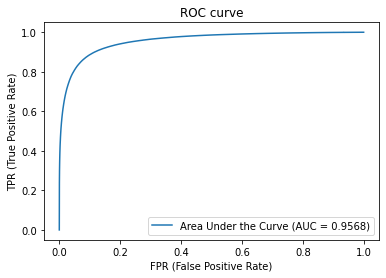

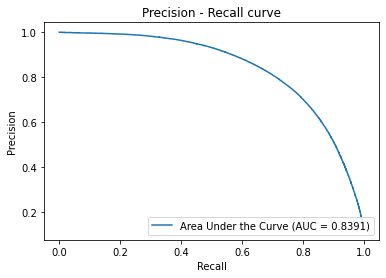

In [ ]:

#================ Run the prediction of the patches ==================================
best_last = 'best'
patches_imgs_test = np.einsum('klij->kijl', patches_imgs_test)

model = M.BCDU_net_D3(input_size = (64,64,1))
model.summary()
model.load_weights('weight_lstm.hdf5')
predictions = model.predict(patches_imgs_test, batch_size=8, verbose=1)

predictions = np.einsum('kijl->klij', predictions)
print(patches_imgs_test.shape)

pred_patches = predictions

print ("predicted images size :")
print (predictions.shape)

#===== Convert the prediction arrays in corresponding images

#========== Elaborate and visualize the predicted images ====================
pred_imgs = None
orig_imgs = None
gtruth_masks = None
if average_mode == True:
    pred_imgs = recompone_overlap(pred_patches, new_height, new_width, stride_height, stride_width)# predictions
    orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
    gtruth_masks = masks_test  #ground truth masks
else:
    pred_imgs = recompone(pred_patches,13,12)       # predictions
    orig_imgs = recompone(patches_imgs_test,13,12)  # originals
    gtruth_masks = recompone(patches_masks_test,13,12)  #masks
# apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!
print('killing border')
kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
## back to original dimensions
orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
np.save('pred_imgs',pred_imgs)
print ("Orig imgs shape: " +str(orig_imgs.shape))
print ("pred imgs shape: " +str(pred_imgs.shape))
print ("Gtruth imgs shape: " +str(gtruth_masks.shape))

np.save('results', pred_imgs)
np.save('origin', gtruth_masks)
assert (orig_imgs.shape[0]==pred_imgs.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)




#====== Evaluate the results
print ("\n\n========  Evaluate the results =======================")
#predictions only inside the FOV
y_scores, y_true = pred_only_FOV(pred_imgs,gtruth_masks, test_border_masks)  #returns data only inside the FOV
print(y_scores.shape)

print ("Calculating results only inside the FOV:")
print ("y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)")
print ("y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)")

#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print ("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"ROC.png")

#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"Precision_recall.png")


#Confusion matrix
threshold_confusion = 0.5
print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print (confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print ("Precision: " +str(precision))

#Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print ("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))



#Save the results
file_perf = open(path_experiment+'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()



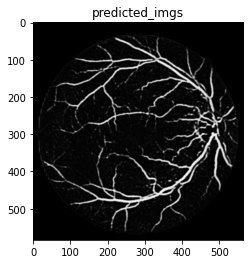

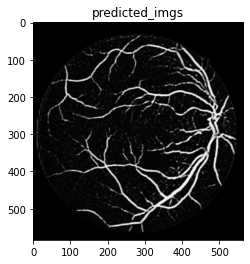

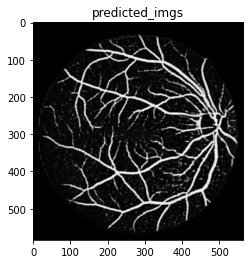

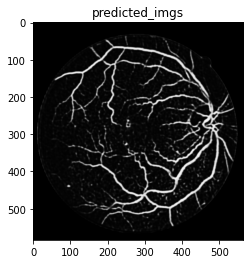

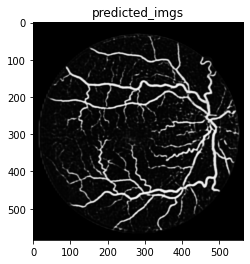

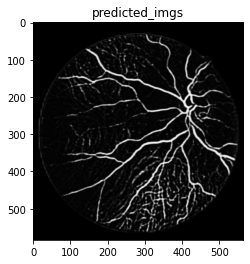

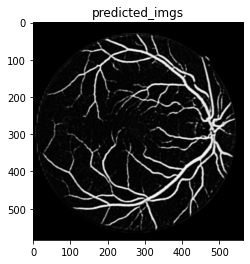

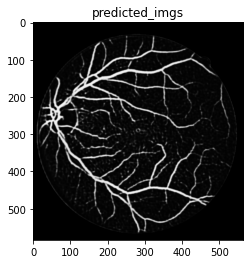

In [ ]:
#visualize and saving segmentation results

import numpy as np
#import scipy.io as sio
import scipy.misc
from keras.preprocessing import image
from skimage.transform import rotate, resize
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from skimage.io import imsave
import cv2
import os

path = "./DRIVE/test/images/"
outputpath = "/content/drive/My Drive/BVsegmentation/BV/test/segmentedBV/"
train_data_type = '.tif'
file_train_list = [file for file in os.listdir(path) if file.lower().endswith(train_data_type)]



for lineIdx in range(0, len(file_train_list)):
    temp_txt = [elt.strip() for elt in file_train_list[lineIdx].split(',')]

      #org_img = np.asarray(image.load_img(path + temp_txt[0]))
    plt.imshow(np.squeeze(pred_imgs[lineIdx]), cmap='gray')
    plt.title('predicted_imgs')
    plt.show()
      #plt.savefig("/content/drive/My Drive/BVsegmentation/trytry/DRIVE/output/")
    imsave(outputpath+temp_txt[0],(pred_imgs))

#for idx in range(8):
#    plt.imshow(np.squeeze(pred_imgs[idx]), cmap='binary')